In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import math

import ruptures as rpt

In [2]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from itertools import product

In [3]:
import yfinance as yf
## FRED 정보 수집 #
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [4]:
# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
# px를 쉽고 빠르게 붙여주는 모듈 cufflinksget_rsi
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [5]:
from scipy.signal import find_peaks
import scipy.fft

In [6]:
%run ../library/QUANT_FUNCTIONS.ipynb
Q = QUANT()
D = DATA()

## Data

In [7]:
## etfs
## df = D.get_merged_df('TQQQ', 'UPRO', 'EURL', 'EDC')

In [8]:
df = D.get_merged_df('^IXIC', 'QQQ')
df = df.dropna()

[*********************100%***********************]  2 of 2 completed


In [9]:
df_ln = np.log(df)

In [10]:
## 페어 확인
df_ln['beta'] = (df_ln['QQQ']/df_ln['^IXIC']).rolling(250*2).mean()
df_ln['e'] = df_ln['QQQ'] - df_ln['beta']*df_ln['^IXIC']

In [11]:
df = D.get_merged_df('^IXIC', '^GSPC', 'GC=F')
DGS20 = fred.get_series('DGS20')
DGS10 = fred.get_series('DGS10')
DGS2 = fred.get_series('DGS2')
DTB3 = fred.get_series('DTB3')
DFF = fred.get_series('DFF')
df = df.fillna(method = 'pad')

[*********************100%***********************]  3 of 3 completed


In [12]:
'''def detect_changes(time_series):
    # Convert time series to a numpy array
    signal = time_series.values

    # Perform change point detection using the Pelt algorithm
    algo = rpt.Pelt(model="rbf", min_size=1, jump=10).fit(signal)
    result = algo.predict(pen=4)

    # remove location if equal to len(signal)
    change_points = [i for i in result if i < len(signal)]

    # Return the list of change point locations
    change_points = [time_series.index[i] for i in change_points]
    
    return change_points


## 변곡점 탐색함수 좀 더 연구해보자.
test = df['^GSPC'].pct_change().dropna().tail(250*20)

point = detect_changes(test)

test.plot()
for i in point:
    plt.axvline(x = i, color = 'red', linestyle = '--', alpha = 0.5)
    
    
## 경기침체
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)   

plt.show()'''

'def detect_changes(time_series):\n    # Convert time series to a numpy array\n    signal = time_series.values\n\n    # Perform change point detection using the Pelt algorithm\n    algo = rpt.Pelt(model="rbf", min_size=1, jump=10).fit(signal)\n    result = algo.predict(pen=4)\n\n    # remove location if equal to len(signal)\n    change_points = [i for i in result if i < len(signal)]\n\n    # Return the list of change point locations\n    change_points = [time_series.index[i] for i in change_points]\n    \n    return change_points\n\n\n## 변곡점 탐색함수 좀 더 연구해보자.\ntest = df[\'^GSPC\'].pct_change().dropna().tail(250*20)\n\npoint = detect_changes(test)\n\ntest.plot()\nfor i in point:\n    plt.axvline(x = i, color = \'red\', linestyle = \'--\', alpha = 0.5)\n    \n    \n## 경기침체\nplt.axvspan(\'2007-12-04\', \'2009-06-01\', facecolor=\'gray\', alpha=0.45)\nplt.axvspan(\'2020-01-31\', \'2020-04-03\', facecolor=\'gray\', alpha=0.45)   \n\nplt.show()'

In [13]:
rate_df = pd.DataFrame([DFF, DTB3, DGS2, DGS10, DGS20], index=['DFF', 'TB3M', 'GS2Y', 'GS10Y', 'GS20Y']).T.fillna(method='pad')

In [14]:
rate_df['1970-01-01':'1975-01-01'].iplot()

In [15]:
df[['^GSPC', '^IXIC']]['1970-01-01':'1975-01-01'].iplot()

In [16]:
rate_df['1999-01-01':'2005-01-01'].iplot()

In [17]:
df['1999-01-01':'2005-01-01'].iplot()

In [18]:
rate_df['2004-12-04':'2012-06-01'].iplot()

In [19]:
df['2004-12-04':'2012-06-01'].iplot()

In [20]:
rate_df['2018-01-01':'2019-12-01'].iplot()

In [21]:
df['2018-01-01':'2019-12-01'].iplot()

In [22]:
rate_df['2021-06-01':].iplot()

In [23]:
df['2021-06-01':].iplot()

<AxesSubplot:>

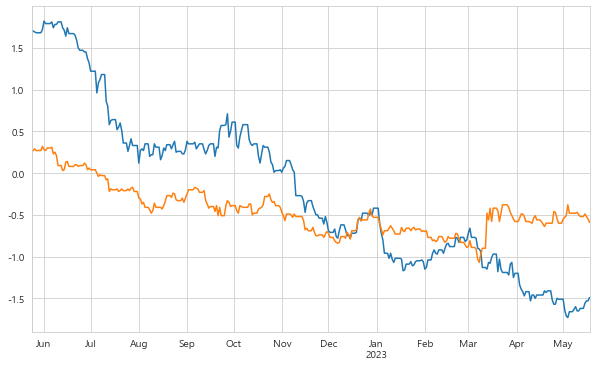

In [24]:
(rate_df['GS10Y'] - rate_df['TB3M']).tail(120*3).plot()
(rate_df['GS10Y'] - rate_df['GS2Y']).tail(120*3).plot()

## Back test

In [25]:
dataset = df.copy()

In [26]:
def get_signals(df, target):
    dataset = df[[target]].copy()
    dataset['M20'] = dataset[target].rolling(20).mean()
    dataset['M60'] = dataset[target].rolling(60).mean()
    dataset['M120'] = dataset[target].rolling(120).mean()
    dataset['M200'] = dataset[target].rolling(200).mean()

    ## dataset['D10'] = dataset[target].max() * (1-.1)
    ## dataset['D20'] = dataset[target].max() * (1-.2)
    ## dataset['D30'] = dataset[target].max() * (1-.3)
    dataset['F-1'] = dataset[target].max() * (0.6180339887498949)
    dataset['F-2'] = dataset[target].max() * (0.38196601125010515)
    dataset['F-3'] = dataset[target].max() * (0.2360679774997897)
    dataset['F-4'] = dataset[target].max() * (0.14589803375031546)
    
    return dataset

In [27]:
def a_to_g(value_g):
    ## 단위 1% 변화가 누적되어 실제변화(value_g)까지 도달하는 산술적 횟수(value_a)
    value_a = np.log(1+0.01*value_g)/np.log(1+0.01)
    
    return value_a

def get_TQP(value_g, pmv=88.57):
    ## 전고점에서 NAQ가 실제변화(value_g)까지 도달했을때 TQQQ의 예상 가격
    fee = 0.08
    price_TQ = pmv*((1+((0.01)*3))**a_to_g(value_g) - fee)
    return price_TQ

In [28]:
ticker = '^IXIC'

In [29]:
df_sig_p1 = get_signals(dataset["1971-06-01":"1977"], ticker)
df_sig_p2 = get_signals(dataset["1999":"2003"], ticker)
df_sig_p3 = get_signals(dataset["2006":"2010"], ticker)
df_sig_p4 = get_signals(dataset["2021-06-01":], ticker)

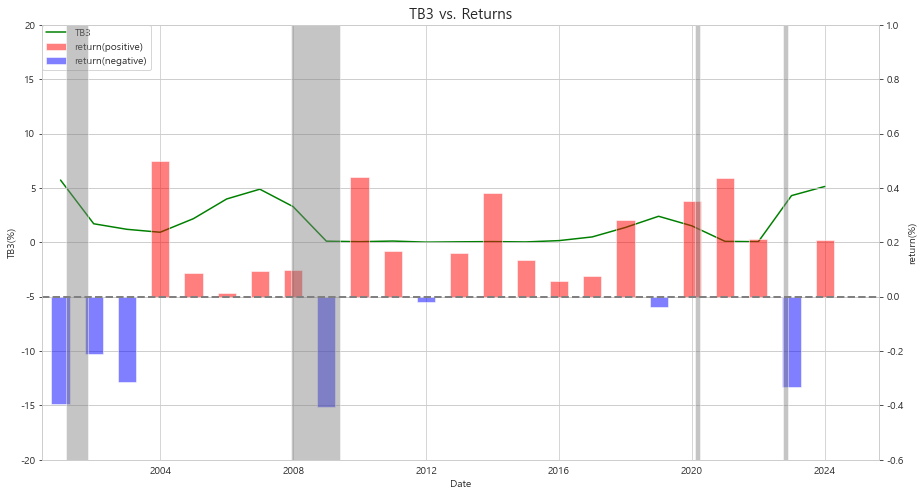

In [30]:
data = dataset.copy()

data['TB3'] = DTB3.copy()
data = data.fillna(method = 'pad')

data = data.resample('Y').last()

data['return'] = data['^IXIC'].pct_change()
data = data.dropna()


fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
ax1.plot(data.index, data['TB3'],
         color="green", label="TB3")
performance_plus = data['return'][data['return']>=0]
ax2.bar(performance_plus.index, performance_plus,
        color="red", alpha=0.5, width=200, label="return(positive)")

performance_minus = data['return'][data['return']<0]
ax2.bar(performance_minus.index, performance_minus,
        color="blue", alpha=0.5, width=200, label="return(negative)")
ax2.axhline(0, color='gray', linestyle='--', linewidth=2)

plt.tick_params(labelsize=10)  # font size of tick labels
plt.title("TB3 vs. Returns", fontsize=15)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
ax1.set_xlabel("Date")
ax1.set_ylabel("TB3(%)")
ax1.set_ylim([-20, 20])
ax1.set_xlim([min(data.index) - dt.timedelta(days=200),
              max(data.index) + dt.timedelta(days=600)])

ax2.set_ylabel("return(%)")
ax2.set_ylim([-.6, 1])


## 경기침체
plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)
plt.axvspan('2022-10-01', '2022-11-25', facecolor='gray', alpha=0.45)

plt.show()

In [31]:
df_sig_p4.iplot()

### Oil-shock

In [32]:
df_sig_p1_1 = get_signals(dataset["1971-02-05":"1975-03-01"], ticker)

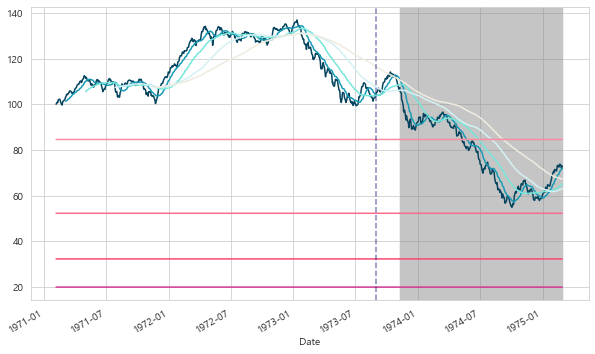

In [33]:
df_sig_p1_1.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

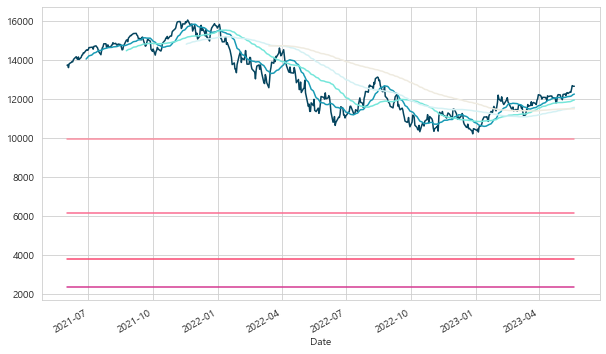

In [34]:
df_sig_p4.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4',
                   '#EFEBE0', '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.show()




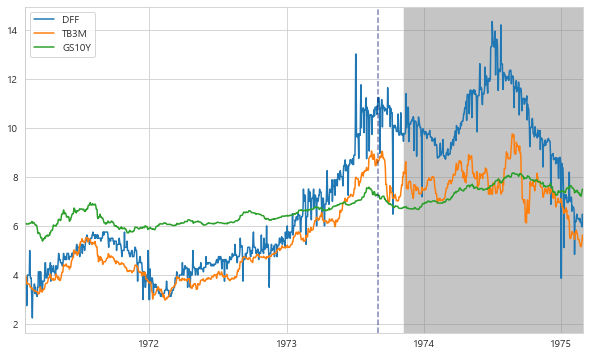

In [35]:
rate_df["1971-02-05":"1975-02-28"][['DFF', 'TB3M', 'GS10Y']].plot()
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

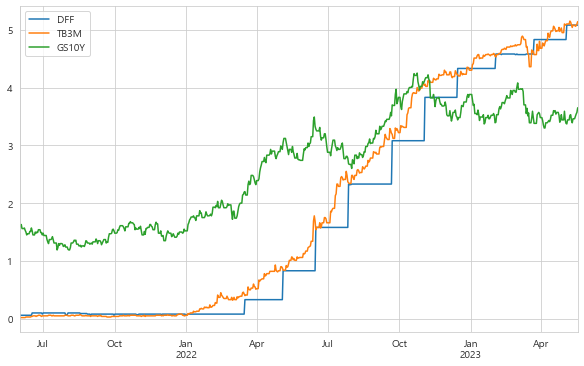

In [36]:
rate_df["2021-06-01":][['DFF', 'TB3M', 'GS10Y']].plot()
plt.show()

### Dot-com

In [37]:
df_sig_p2_1 = get_signals(dataset["1999-12-01":"2002-01-01"], ticker)

In [38]:
df_sig_p4['^IXIC'].min()
df_sig_p1_1['^IXIC'][:'1973-09-01'].min()

99.38999938964844

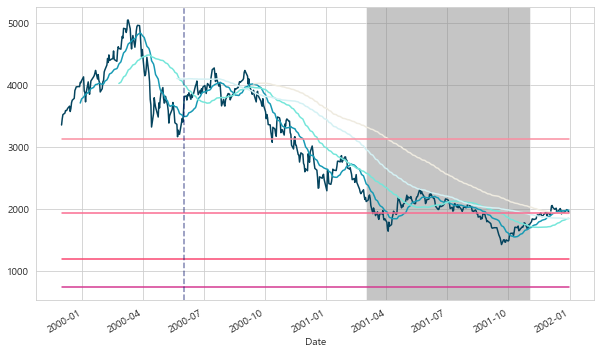

In [39]:
df_sig_p2_1.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#EFEBE0',
                   '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvline(x = '2000-06-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

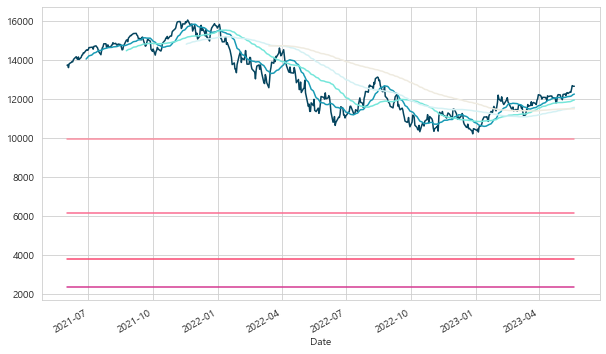

In [40]:
df_sig_p4.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#EFEBE0',
                   '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.show()




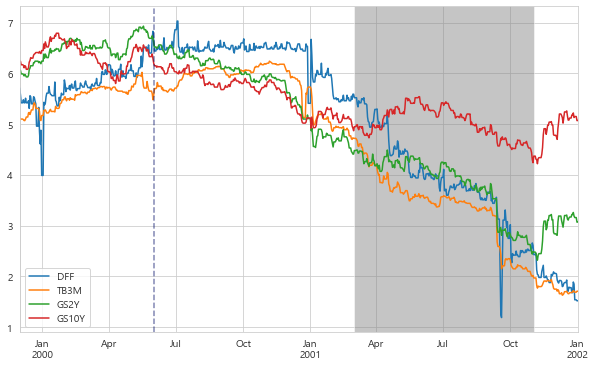

In [41]:
rate_df["1999-12-01":"2002-01-01"][['DFF', 'TB3M', 'GS2Y', 'GS10Y']].plot()
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvline(x = '2000-06-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

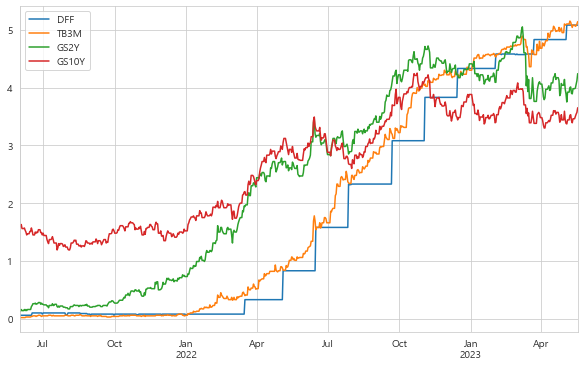

In [42]:
rate_df["2021-06-01":][['DFF', 'TB3M', 'GS2Y', 'GS10Y']].plot()
plt.show()

In [43]:
df_sig = get_signals(dataset["1971-02-05":"1975-06-30"], ticker)

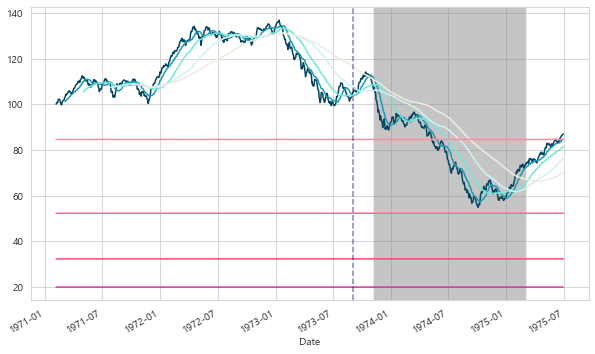

In [44]:
df_sig.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#EFEBE0',
                   '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvline(x = '1973-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.show()

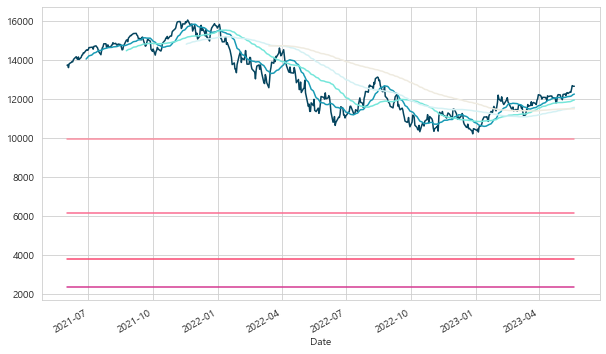

In [45]:
df_sig_p4.plot(legend=False, color=['#05445E', '#189AB4', '#75E6DA', '#D4F1F4', '#EFEBE0',
                   '#FB8DA0', '#FB6B90', '#FB4570', '#D43790', '#EC8FD0', '#870A30'])
## plt.yscale("log")
plt.show()




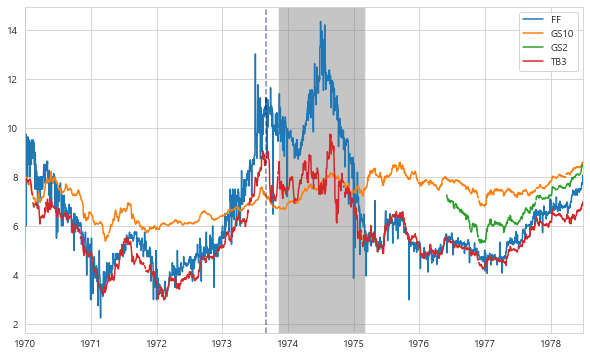

In [46]:
DFF["1970-01-01":"1978-06-30"].plot()
DGS10["1970-01-01":"1978-06-30"].plot()
DGS2["1970-01-01":"1978-06-30"].plot()
DTB3["1970-01-01":"1978-06-30"].plot()
plt.legend(['FF', 'GS10', 'GS2', 'TB3'])
plt.axvline(x = '1973-09-01', color = '#000C66', linestyle = '--', alpha = 0.5)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)

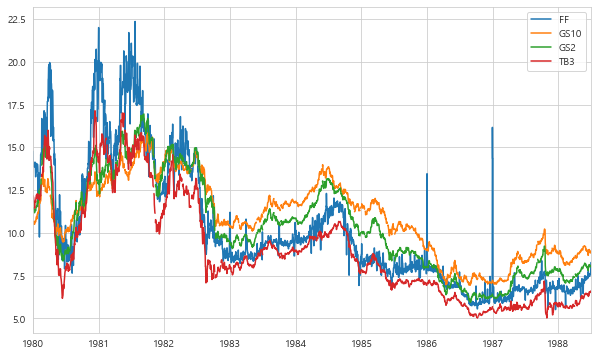

In [47]:
DFF["1980-01-01":"1988-06-30"].plot()
DGS10["1980-01-01":"1988-06-30"].plot()
DGS2["1980-01-01":"1988-06-30"].plot()
DTB3["1980-01-01":"1988-06-30"].plot()
plt.legend(['FF', 'GS10', 'GS2', 'TB3'])

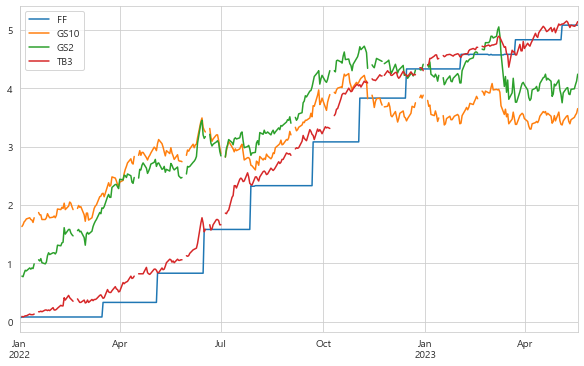

In [48]:
DFF["2022":].plot()
DGS10["2022":].plot()
DGS2["2022":].plot()
DTB3["2022":].plot()
plt.legend(['FF', 'GS10', 'GS2', 'TB3'])

In [49]:
data = pd.concat([DFF, DTB3, DGS10], axis=1)
data.columns = ['DFF', 'T3M', 'T10Y']
data['T10Y3M'] = data['T10Y'] - data['T3M']
data = data.fillna(method='pad').dropna()

In [50]:
sns.set_style('white')
## sns.set_style('whitegrid')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

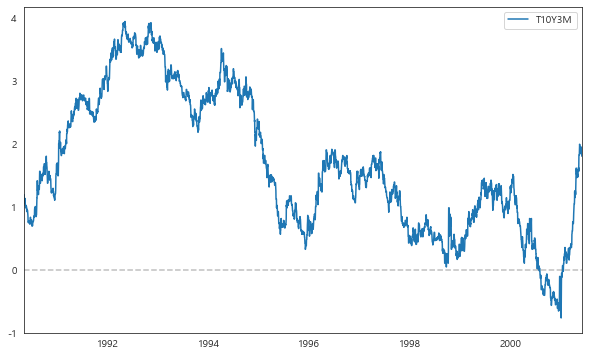

In [51]:
data[['T10Y3M']]["1990-05-01":"2001-06-01"].plot()
plt.axhline(0, color = 'gray', linestyle = '--', alpha = 0.5)

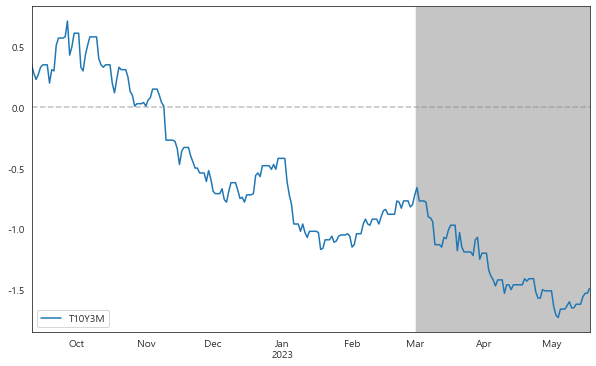

In [52]:
data[['T10Y3M']].tail(250).plot()
plt.axhline(0, color = 'gray', linestyle = '--', alpha = 0.5)

## 경기침체
plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)
plt.axvspan('2023-03-01', '2023-06-30', facecolor='gray', alpha=0.45)

In [53]:
## 경기침체와 MDD
df = dataset.copy()
srs = df[ticker]
df['hp'] = [srs[:i+1].max() for i in range(len(srs))]
df['mdd'] = (df[ticker] - df['hp'])/df['hp']

df['경기침체'] = '정상'
df['경기침체']['1969-12-01':'1970-10-29'] = '달러위기'
df['경기침체']['1973-11-05':'1975-03-03'] = '1차오일쇼크'
df['경기침체']['1980-01-02':'1980-07-02'] = '2차오일쇼크'
df['경기침체']['1981-07-01':'1982-11-03'] = '물가충격'
df['경기침체']['1990-07-05':'1991-03-01'] = '걸프전'
df['경기침체']['2001-03-02':'2001-11-02'] = '닷컴버블'
df['경기침체']['2007-12-04':'2009-06-01'] = '금융위기'
df['경기침체']['2020-01-31':'2020-04-03'] = '코로나'
df['경기침체']['2022-10-01':'2022-11-18'] = '신물가쇼크'

df['10Y3M'] = (rate_df['GS10Y'] - rate_df['TB3M'])
df['2Y3M'] = (rate_df['GS2Y'] - rate_df['TB3M'])

## df['mdd'] = df['mdd']*5

In [54]:
df[['mdd', '10Y3M', '2Y3M']].dropna().iplot()

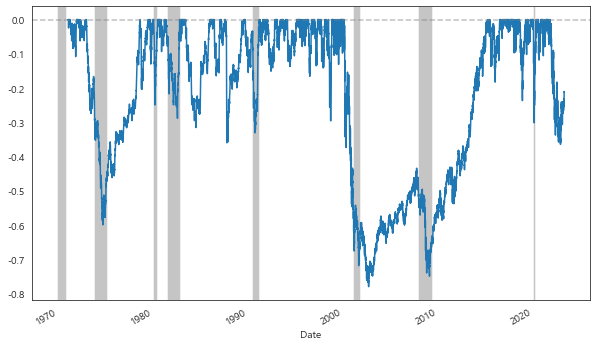

In [55]:
df['mdd'].plot()
plt.axhline(0, color = 'gray', linestyle = '--', alpha = 0.5)
## 경기침체
plt.axvspan('1969-12-01', '1970-10-29', facecolor='gray', alpha=0.45)
plt.axvspan('1973-11-05', '1975-03-03', facecolor='gray', alpha=0.45)
plt.axvspan('1980-01-02', '1980-07-02', facecolor='gray', alpha=0.45)
plt.axvspan('1981-07-01', '1982-11-03', facecolor='gray', alpha=0.45)
plt.axvspan('1990-07-05', '1991-03-01', facecolor='gray', alpha=0.45)
plt.axvspan('2001-03-02', '2001-11-02', facecolor='gray', alpha=0.45)
plt.axvspan('2007-12-04', '2009-06-01', facecolor='gray', alpha=0.45)
plt.axvspan('2020-01-31', '2020-04-03', facecolor='gray', alpha=0.45)
## plt.axvspan('2022-10-01', '2022-11-18', facecolor='gray', alpha=0.45)

## 임시

In [56]:
test = pd.pivot_table(df, index='경기침체', values = 'mdd', aggfunc=min).reset_index()

<AxesSubplot:xlabel='mdd', ylabel='Density'>

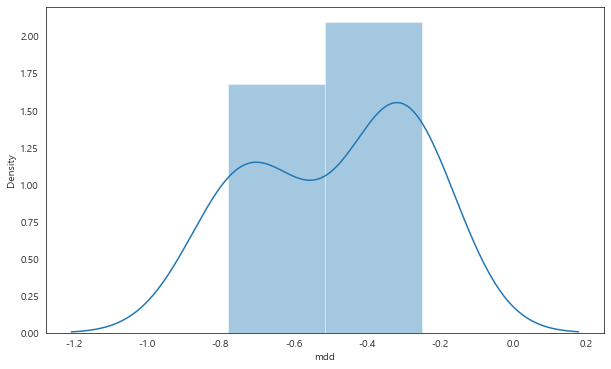

In [57]:
sns.distplot(test['mdd'])

In [58]:
import scipy as sp
import scipy.stats

In [59]:
def show_pdfcdf(rv, m, s):
    mm = m
    ss = 6 * s
    xx = np.linspace(mm - ss, mm + ss, 200)
    pdf = rv.pdf(xx)
    cdf = rv.cdf(xx)

    plt.grid(True)
    plt.plot(xx, pdf)
    ## plt.plot(xx, cdf)
    plt.title(f" Norm(m={m}, s^2={s*s:.3f}) Pdf")
    plt.savefig("dist.png")
    plt.show()

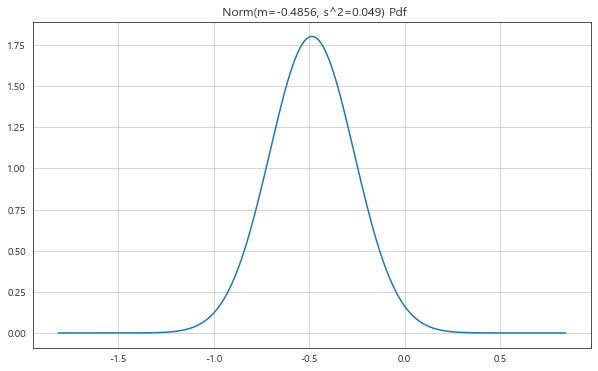

In [60]:
m, s = -0.4856, 0.2214
rv = sp.stats.norm(m, s)

show_pdfcdf(rv, m, s)

In [61]:
1 - rv.cdf(-0.70)

0.8335734410656466

In [62]:
rv.cdf(-0.35) - rv.cdf(-0.55)

0.34431231194844986

In [63]:
rv.cdf(-0.55)

0.38557298605708584

In [64]:
1 - rv.cdf(-0.35)

0.2701147019944643

<AxesSubplot:>

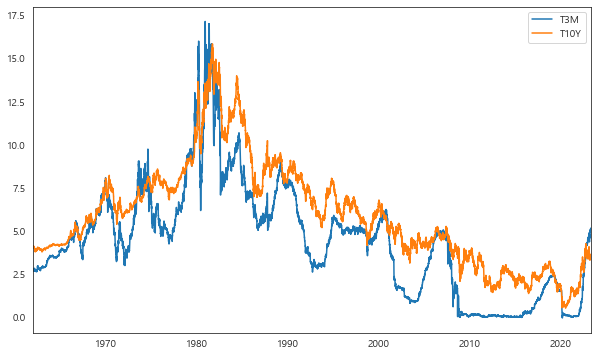

In [65]:
data[['T3M', 'T10Y']].plot()

KeyError: '^IXIC'

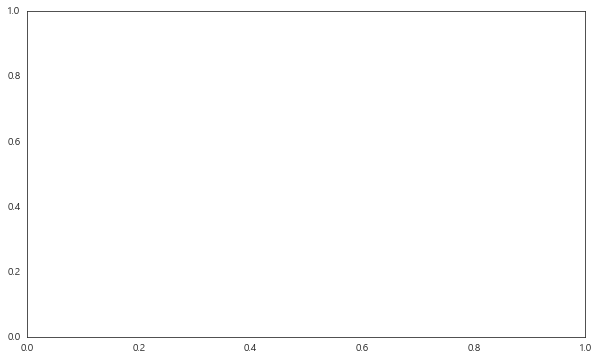

In [66]:
fig, ax1 = plt.subplots()

line1 = ax1.plot(data.index, data[ticker], color = '#05445E', alpha = 0.8, label='S&P500지수', linewidth = 2, linestyle = '-')
line1_2 = ax1.plot(data.index, data['M20'], color = '#189AB4', alpha = 0.7, linewidth = 1, linestyle = '-')
line1_3 = ax1.plot(data.index, data['M60'], color = '#75E6DA', alpha = 0.6, linewidth = 1, linestyle = '-')
line1_4 = ax1.plot(data.index, data['M120'], color = '#D4F1F4', alpha = 0.6, linewidth = 1, linestyle = '-')
line1_5 = ax1.plot(data.index, data['M200'], color = '#EFEBE0', alpha = 0.5, linewidth = 1, linestyle = '-')

## plt.fill_between(data['1973-01-11':'1974-10-03'].index, data['1973-01-11':'1974-10-03']['^GSPC'], color='lightgray', alpha=0.5)

ax1.axvspan('1973-01-11', '1974-10-03', facecolor='#FB8DA0', alpha=0.25)

plt.hlines(data['^GSPC'].max(), data['1972-06-01':'1976-06-01'].index[0], data['1972-06-01':'1975-06-01'].index[-1], color='#FB4570', linestyle='--', linewidth=3, alpha=0.7)

plt.hlines(data['^GSPC'].min(), data['1972-06-01':'1976-06-01'].index[0], data['1972-06-01':'1975-06-01'].index[-1], color='#FB4570', linestyle='--', linewidth=3, alpha=0.7)

ax1.set_ylim(60, 125)
ax1.set_xlim(data.index[0], data.index[-1])

ax1.legend(loc='upper left')

plt.figimage(im_wm, xo=500, yo=30, resize=False, alpha=0.25)
plt.show()